

# TEAM PROJECT

> Install packages






In [1]:
!pip install gym-minigrid minigrid

> Import packages

In [2]:
import gymnasium as gym
import minigrid
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
from copy import deepcopy
import matplotlib.pyplot as plt

In [3]:
def set_seed(seed: int, env=None):
    import random, numpy as np, torch

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    if env is not None:
        env.reset(seed=seed)
        env.action_space.seed(seed)          # Discrete에도 정상 적용
        env.observation_space.seed(seed)

## Training Environment

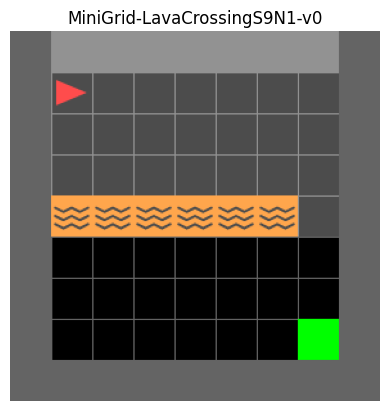

In [21]:
env = gym.make("MiniGrid-LavaCrossingS9N1-v0", render_mode="rgb_array")
obs, info = env.reset(seed=1)

frame = env.render()  # numpy array (H, W, 3)

plt.imshow(frame)
plt.axis("off")
plt.title("MiniGrid-LavaCrossingS9N1-v0")
plt.show()

env.close()

In [22]:
class CNNQNetwork(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1), nn.ReLU(),
            nn.Flatten()
        )
        # obs["image"] shape = (7,7,3)
        dummy = torch.zeros(1, 3, 7, 7)  # (B,C,H,W)
        conv_out_dim = self.conv(dummy).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(conv_out_dim, 128), nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        # x: (B,H,W,C) → (B,C,H,W)
        if x.ndim == 3:
            x = x.unsqueeze(0)
        x = x.permute(0, 3, 1, 2).float() / 255.0
        z = self.conv(x)
        return self.fc(z)

In [27]:
class DQNAgent:
    def __init__(self, q_network, optimizer, output_dim,
                 epsilon_start=1.0, epsilon_final=0.05, epsilon_decay=0.995,
                 target_update=100, batch_size=64, memory_capacity=50000,
                 gamma=0.99, tau=1.0):
        self.q_network = q_network
        self.target_network = deepcopy(q_network)
        self.target_network.eval()
        self.optimizer = optimizer

        self.output_dim = output_dim
        self.epsilon = epsilon_start
        self.epsilon_final = epsilon_final
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau

        self.memory = deque(maxlen=memory_capacity)
        self.steps = 0
        self.criterion = nn.MSELoss()

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.output_dim - 1)
        s = torch.tensor(state["image"], dtype=torch.float32)
        with torch.no_grad():
            q_values = self.q_network(s)
        return q_values.argmax().item()

    def store(self, state, action, reward, next_state, done):
        self.memory.append((state["image"], action, reward, next_state["image"], done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states), dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1).values
        expected_q = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.criterion(q_values, expected_q)

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_network.parameters(), 10.0)
        self.optimizer.step()

        self.epsilon = max(self.epsilon_final, self.epsilon * self.epsilon_decay)
        self.steps += 1

        if self.steps % self.target_update == 0:
            for t, q in zip(self.target_network.parameters(), self.q_network.parameters()):
                t.data.copy_(t.data * (1 - self.tau) + q.data * self.tau)

In [28]:
env = gym.make("MiniGrid-LavaCrossingS9N1-v0", render_mode="rgb_array")
set_seed(1, env)
output_dim = env.action_space.n
q_net = CNNQNetwork(output_dim)
optimizer = optim.Adam(q_net.parameters(), lr=1e-3)
agent = DQNAgent(
    q_net,
    optimizer,
    output_dim=output_dim,
    epsilon_start=1.0,
    epsilon_final=0.05,
    epsilon_decay=0.995,
    target_update=100,
    batch_size=64,
    memory_capacity=50_000,
    gamma=0.99,
    tau=1.0
)

In [ ]:
num_episodes=100
max_steps=env.unwrapped.max_steps

for ep in range(num_episodes):
    state, _ = env.reset(seed=1)
    total_reward = 0
    steps = 0
    for t in range(max_steps):
        steps += 1
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        agent.store(state, action, reward, next_state, float(done))
        agent.train()

        state = next_state
        total_reward += reward

        if done:
            break

    ### If you want to check how the episode ended, please activate the code below. ###
    # frame = env.render()

    # plt.imshow(frame)
    # plt.axis("off")
    # plt.title("MiniGrid-LavaCrossingS9N1-v0")
    # plt.show()

    print(f"Episode {ep+1:3d} | Reward: {total_reward:.2f} | Epsilon: {agent.epsilon:.3f} | Steps: {steps:.3f}")

## Save Parameters

In [ ]:
torch.save(agent.q_network.state_dict(), "dqn_minigrid.pth")
print("Agent saved as dqn_minigrid.pth")

## Load Parameters

In [ ]:
q_net_loaded = CNNQNetwork(env.action_space.n)
q_net_loaded.load_state_dict(torch.load("dqn_minigrid.pth"))
q_net_loaded.eval()


In [38]:
# load agent
optimizer = optim.Adam(q_net.parameters(), lr=1e-3)
agent_loaded = DQNAgent(q_net_loaded, optimizer, output_dim=output_dim)

## Evaluation Environment

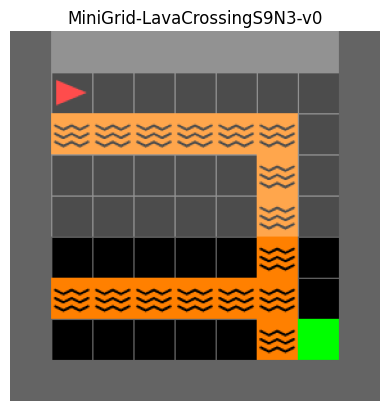

In [43]:
env = gym.make("MiniGrid-LavaCrossingS9N3-v0", render_mode="rgb_array")
obs, info = env.reset(seed=2)

frame = env.render()  # numpy array (H, W, 3)

plt.imshow(frame)
plt.axis("off")
plt.title("MiniGrid-LavaCrossingS9N3-v0")
plt.show()

env.close()

In [ ]:
eval_env = gym.make("MiniGrid-LavaCrossingS9N3-v0", render_mode="rgb_array")
set_seed(2, eval_env)

num_eval_episodes = 100
max_steps = eval_env.unwrapped.max_steps

sum_reward = 0

for i in range(num_eval_episodes):
    state, _ = eval_env.reset(seed=2)
    total_reward = 0
    steps = 0

    while True:
        steps += 1
        saved_epsilon = agent_loaded.epsilon
        agent_loaded.epsilon = 0.1
        action = agent_loaded.select_action(state)
        agent_loaded.epsilon = saved_epsilon

        next_state, reward, terminated, truncated, info = eval_env.step(action)
        total_reward += reward
        state = next_state

        if terminated or truncated or steps >= max_steps:
            break
    sum_reward += total_reward
    print(f"[Eval Ep {i+1}] Reward: {total_reward:.2f} | Steps: {steps}")
    frame = eval_env.render()

    plt.imshow(frame)
    plt.axis("off")
    plt.title("MiniGrid-LavaCrossingS9N1-v0")
    plt.show()
eval_env.close()

print(f"Evaluation: {sum_reward}")